In [72]:

import psycopg2
from psycopg2 import sql
import requests
import pandas as pd

DB_PARAMS = {
    "dbname": "mydatabase",    
    "user": "myuser",          
    "password": "mypassword",  
    "host": "localhost",       
    "port": 5432               
}
def get_connection():
    """Establish and return a new database connection."""
    return psycopg2.connect(**DB_PARAMS)

def create_schema(schema):

    conn = get_connection()
    try:
        with conn:
            with conn.cursor() as cur:
                query = sql.SQL("CREATE SCHEMA IF NOT EXISTS {schema}")
                cur.execute(query.format(schema=sql.Identifier(schema)))
                print(f"Schema '{schema}' created or already exists.")
    finally:
        conn.close()

def get_address_transactions(schema, table_name, address, inout):


    conn = get_connection()
    
    query = sql.SQL(f"""
        SELECT block, to_address, from_address, size, hash
        FROM {schema}."{table_name}"
        WHERE {inout}_address = %s
        ORDER BY block ASC;
    """)

    df = pd.read_sql_query(query.as_string(conn), conn, params=(address,))

    conn.close()

    return df
        
def create_token_table(schema, token):

    conn = get_connection()
    table_name = token.lower()  # For example, "ETH" becomes "eth"
    try:
        with conn:
            with conn.cursor() as cur:
                query = sql.SQL("""
                    CREATE TABLE IF NOT EXISTS {schema}.{table} (
                        block INTEGER NOT NULL,
                        to_address TEXT NOT NULL,
                        from_address TEXT NOT NULL,
                        size NUMERIC,
                        hash TEXT NOT NULL UNIQUE
                    );
                """).format(
                    schema=sql.Identifier(schema),
                    table=sql.Identifier(table_name)
                )
                cur.execute(query)
                print(f"Table '{table_name}' created in schema '{schema}'.")
    finally:
        conn.close()

def insert_token_event(schema, token, block, to_address, from_address, size, hash_val):


    conn = get_connection()
    table_name = token.lower()
    try:
        with conn:
            with conn.cursor() as cur:
                query = sql.SQL("""
                    INSERT INTO {schema}.{table} (block, to_address, from_address, size, hash)
                    VALUES (%s, %s, %s, %s, %s)
                    ON CONFLICT (hash) DO NOTHING;
                """).format(
                    schema=sql.Identifier(schema),
                    table=sql.Identifier(table_name)
                )
                cur.execute(query, (block, to_address, from_address, size, hash_val))
                print(f"Inserted event into table '{table_name}' in schema '{schema}'.")
    finally:
        conn.close()


def exists_blocks(schema, token, start_block, end_block):

    conn = get_connection()
    table_name = token.lower()
    try:
        with conn.cursor() as cur:
            query = sql.SQL("""
                SELECT DISTINCT block
                FROM {schema}.{table}
                WHERE block BETWEEN %s AND %s;
            """).format(
                schema=sql.Identifier(schema),
                table=sql.Identifier(table_name)
            )
            cur.execute(query, (start_block, end_block))
            # Get the set of block numbers that exist in the DB.
            existing_blocks = {row[0] for row in cur.fetchall()}
            
            # Create the set of all expected block numbers.
            expected_blocks = set(range(start_block, end_block + 1))
            missing = sorted(list(expected_blocks - existing_blocks))
            return len(missing) == 0, missing
    finally:
        conn.close()


In [73]:

def get_transfers_stark(token_address, address, start_block, end_block):
    host = "https://starknet-mainnet.public.blastapi.io/rpc/v0_7"
    JUNO_RPC_URL = host
    
    payload = {
        "jsonrpc": "2.0",
        "method": "starknet_getEvents",
        "params": {
            "filter": {
                "from_block": {"block_number": start_block},
                "to_block": {"block_number": end_block},
                "address": token_address,
                "keys": [
                    ["0x99cd8bde557814842a3121e8ddfd433a539b8c9f14bf31ebf108d12e6196e9"]
                ],
                "chunk_size": 500
            }
        },
        "id": 1
    }
    
    all_events = []
    response = requests.post(JUNO_RPC_URL, json=payload)
    data = response.json()
    
    # Debug print
    print("API Response:", data)
    
    result = data.get("result", {})
    all_events.extend(result.get("events", []))
    continuation_token = result.get("continuation_token")
    
    while continuation_token:
        payload["params"]["filter"]["continuation_token"] = continuation_token
        payload["id"] += 1
        response = requests.post(JUNO_RPC_URL, json=payload)
        data = response.json()
        result = data.get("result", {})
        all_events.extend(result.get("events", []))
        continuation_token = result.get("continuation_token")

    # Debug print
    if all_events:
        print("Sample event:", all_events[0])

    formatted_events = []
    for event in all_events:
        d = event.get("data", [])
        if len(d) >= 3:
            event_dict = {
                "from_address": d[0],
                "to_address": d[1],
                "size": float(int(d[2], 16) / (10 ** 18)),
                "block": int(event.get("block_number", 0)),
                "hash": event.get("transaction_hash")
            }
            formatted_events.append(event_dict)
    
    # Debug print
    if formatted_events:
        print("Sample formatted event:", formatted_events[0])
    
    df = pd.DataFrame(formatted_events)
    
    # Debug print
    print("DataFrame columns:", df.columns.tolist())
    print("DataFrame head:", df.head())
    
    return df

def get_and_insert_transfers(token_address, network, start_block, end_block):
    if network == "starknet":
        create_schema(network)
        create_token_table(network, token_address)
        table_name = token_address.lower()
        
        df = get_transfers_stark(token_address, "address", start_block, end_block)
        
        if df.empty:
            print("No events found in the specified block range")
            return
            
        # Make sure all required columns exist
        required_columns = ['block', 'to_address', 'from_address', 'size', 'hash']
        missing_columns = [col for col in required_columns if col not in df.columns]
        if missing_columns:
            raise ValueError(f"Missing required columns: {missing_columns}")
        
        df = df.sort_values(by='block')
        
        for _, row in df.iterrows():
            try:
                insert_token_event(
                    network,
                    table_name,
                    row['block'],
                    row['to_address'],
                    row['from_address'],
                    row['size'],
                    row['hash']
                )
            except Exception as e:
                print(f"Error inserting row: {row}")
                print(f"Error message: {str(e)}")
    else:
        pass

#get_and_insert_transfers("0x04718f5a0fc34cc1af16a1cdee98ffb20c31f5cd61d6ab07201858f4287c938d", "starknet", start_block=1000000, end_block=1001000)
get_address_transactions("starknet", "0x04718f5a0fc34cc1af16a1cdee98ffb20c31f5cd61d6ab07201858f4287c938d", "0xfff107e2403123c7df78d91728a7ee5cfd557aec0fa2d2bdc5891c286bbfff", "from")

/var/folders/td/d5hldtfd6mb0jr3h2259jlt40000gn/T/ipykernel_1007/3762112535.py:41: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query.as_string(conn), conn, params=(address,))


,block,to_address,from_address,size,hash
0,1000045,0x1114c7103e12c2b2ecbd3a2472ba9c48ddcbf702b1c2...,0xfff107e2403123c7df78d91728a7ee5cfd557aec0fa2...,5.793320e+00,0x2f4f0b4a295c5ecde19b5dcb23d75cb1a34e67dd02dd...
1,1000482,0x1114c7103e12c2b2ecbd3a2472ba9c48ddcbf702b1c2...,0xfff107e2403123c7df78d91728a7ee5cfd557aec0fa2...,8.764964e+00,0x392d5d0bf65abde798039ae36899b0e35df5bcf6d6e4...
2,1000489,0x1941395947349bf37c49f449ed7bec266cab1e91709b...,0xfff107e2403123c7df78d91728a7ee5cfd557aec0fa2...,9.338700e-14,0x66073d893e504fa17124b88688b0dd7e7b2346652acb...
3,1000495,0x1941395947349bf37c49f449ed7bec266cab1e91709b...,0xfff107e2403123c7df78d91728a7ee5cfd557aec0fa2...,1.016193e-07,0xb841383f0170ac93a240f91088a9e4773cec6235f41d...
4,1000580,0x1114c7103e12c2b2ecbd3a2472ba9c48ddcbf702b1c2...,0xfff107e2403123c7df78d91728a7ee5cfd557aec0fa2...,2.544651e-01,0x5829ebcf7c947c895c32cbb198b135e41abd09e42b0d...
5,1000582,0x1114c7103e12c2b2ecbd3a2472ba9c48ddcbf702b1c2...,0xfff107e2403123c7df78d91728a7ee5cfd557aec0fa2...,8.158319e+00,0x4edaca4a1a7ad500d21b0019972a1eb44bfca6856842...
6,1000632,0x1a331c24edee810d903d06835a2c091e38998de4cc25...,0xfff107e2403123c7df78d91728a7ee5cfd557aec0fa2...,8.454561e-10,0x734cfb2d45ab48112f5552da34881b19bd639d6eef08...
7,1000688,0x1114c7103e12c2b2ecbd3a2472ba9c48ddcbf702b1c2...,0xfff107e2403123c7df78d91728a7ee5cfd557aec0fa2...,2.301025e-01,0x202d9380fa15142994c6519cf93282775dbfc68da311...
8,1000768,0x59c747fd31a24430cfd3bbf8551e5c483bc0a4bbcb89...,0xfff107e2403123c7df78d91728a7ee5cfd557aec0fa2...,2.582090e+01,0x76c0c5785f0690a843537e61d713f518a7d356712837...
9,1000769,0x61890945d1b30e255d9234e47a14a9be1c5ee3b76ffd...,0xfff107e2403123c7df78d91728a7ee5cfd557aec0fa2...,6.267558e-01,0x3ced3c9827e5b9ef34288d20e1630c79bdc2b96202a5...


Graph constructed with:
 - 7 nodes
 - 6 edges


/var/folders/td/d5hldtfd6mb0jr3h2259jlt40000gn/T/ipykernel_1007/3762112535.py:41: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query.as_string(conn), conn, params=(address,))


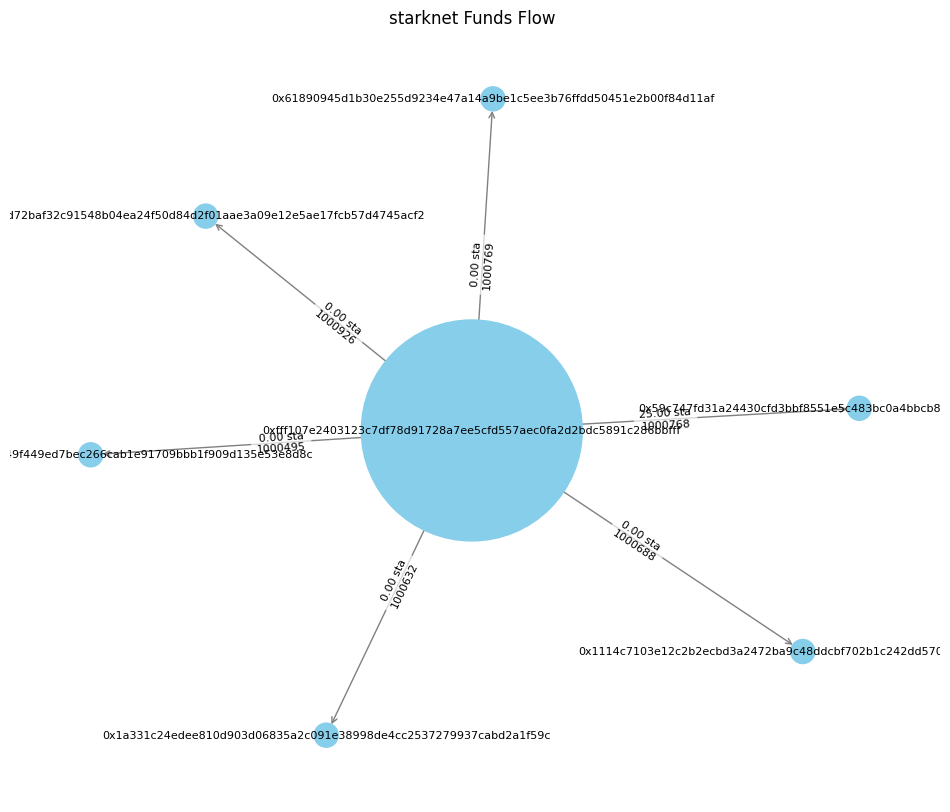

In [74]:
import networkx as nx
import matplotlib.pyplot as plt
tx_list = get_address_transactions("starknet", "0x04718f5a0fc34cc1af16a1cdee98ffb20c31f5cd61d6ab07201858f4287c938d", "0xfff107e2403123c7df78d91728a7ee5cfd557aec0fa2d2bdc5891c286bbfff", "from")
tx_list = tx_list.rename(columns={
    'block': 'blockNumber',
    'to_address': 'to',
    'from_address': 'from',
    'size': 'value', 
    'hash': 'hash'
})
initial_address = "0xfff107e2403123c7df78d91728a7ee5cfd557aec0fa2d2bdc5891c286bbfff"
tx_list = tx_list.to_dict('records')

def create_graph(tx_list, initial_address, token):
    # Create a directed graph
    G = nx.DiGraph()
    # Add the initial address as a node
    G.add_node(initial_address)
    
    # Process each transaction to add nodes and edges
    for tx in tx_list:
        # Make sure this is an outbound transaction
        if tx['from'] != initial_address:
            continue
        
        sender = tx['from']
        receiver = tx['to']
        # Convert value from Wei to ETH (1 ETH = 10^18 Wei)
        value_eth = int(tx['value'])
        block_number = tx['blockNumber']
        
        # Add nodes if not already added
        G.add_node(sender)
        G.add_node(receiver)
        
        # Add an edge from sender to receiver with transaction attributes
        G.add_edge(sender, receiver, value=value_eth, block=block_number,)
        
    print("Graph constructed with:")
    print(f" - {G.number_of_nodes()} nodes")
    print(f" - {G.number_of_edges()} edges")
    
    node_total_value = {}
    for node in G.nodes():
        total = sum(data['value'] for _, _, data in G.out_edges(node, data=True))
        node_total_value[node] = total
    
    # Set node sizes (base size + scale factor * total ETH)
    node_sizes = [300 + 1000 * node_total_value.get(node, 0) for node in G.nodes()]
    
    # --- Prepare edge labels that include the ETH value and transaction date ---
    edge_labels = {}
    for u, v, data in G.edges(data=True):
        block_number = data.get('block', 'NA')
        label = f"{data.get('value', 0):.2f} {token[:3]}\n{block_number}"
        edge_labels[(u, v)] = label
    
    # --- Layout and Drawing ---
    plt.figure(figsize=(12, 10))
    pos = nx.spring_layout(G, k=0.5, iterations=20)
    
    # Draw nodes with the calculated sizes
    nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color='skyblue')
    
    # Draw edges with arrows
    nx.draw_networkx_edges(G, pos, arrowstyle='->', arrowsize=10, edge_color='gray')
    
    # Draw node labels
    nx.draw_networkx_labels(G, pos, font_size=8)
    
    nx.draw_networkx_edge_labels(
        G, pos, edge_labels=edge_labels, font_size=8,
        bbox=dict(facecolor='white', edgecolor='none', alpha=0.7)
    )
    plt.title(f"{token} Funds Flow ")
    plt.axis('off')
    plt.show()

create_graph(tx_list, initial_address, "starknet")

In [75]:
host = "https://starknet-mainnet.public.blastapi.io/rpc/v0_7"


JUNO_RPC_URL = host
import requests
import json


JUNO_RPC_URL = host


stark_address = "0x04718f5a0fc34cc1af16a1cdee98ffb20c31f5cd61d6ab07201858f4287c938d"


payload = {
    "jsonrpc": "2.0",
    "method": "starknet_getEvents",
    "params": {
        "filter": {
            "from_block": "latest",
            "to_block": "latest",
            "address": stark_address,
            "keys": [
                [
                    "0x99cd8bde557814842a3121e8ddfd433a539b8c9f14bf31ebf108d12e6196e9"
                ]
            ],
            "chunk_size": 1000
        }
    },
    "id": 1
}

response = requests.post(JUNO_RPC_URL, json=payload)
data = response.json()
print(json.dumps(data, indent=2))


{
  "jsonrpc": "2.0",
  "result": {
    "events": [
      {
        "block_hash": "0x62e57704aaf60fb68cd5985550a9c0d34f13fb7bd94f87724fe75df37c49d29",
        "block_number": 1136777,
        "data": [
          "0x5dd3d2f4429af886cd1a3b08289dbcea99a294197e9eb43b0e0325b4b",
          "0x4270219d365d6b017231b52e92b3fb5d7c8378b05e9abc97724537a80e93b0f",
          "0x13d89fc2b54017a8444",
          "0x0"
        ],
        "from_address": "0x4718f5a0fc34cc1af16a1cdee98ffb20c31f5cd61d6ab07201858f4287c938d",
        "keys": [
          "0x99cd8bde557814842a3121e8ddfd433a539b8c9f14bf31ebf108d12e6196e9"
        ],
        "transaction_hash": "0x18b11ed17e4daa6419a8b78d4fdc13cb6e85617161ea22e3758428297f9dc23"
      },
      {
        "block_hash": "0x62e57704aaf60fb68cd5985550a9c0d34f13fb7bd94f87724fe75df37c49d29",
        "block_number": 1136777,
        "data": [
          "0x4270219d365d6b017231b52e92b3fb5d7c8378b05e9abc97724537a80e93b0f",
          "0x360fb3a51bd291e5db0892b6249918a5689bc6